# TAL Research
## **Modelling: Part 2 of 4** - Feature Selection and Modelling for Email data with Accounts Data


**Objective**: Develop a small scale model based on the data provided to appropriately help the team prioritize accounts for our sales reps to target.

**What we know**:
- **unique ID** is the id_number, i.e. every id number belongs to a unique company. This is important because it determines how we will consider (concatenate) the different datasets (excel files) with each other.

**Datasets**:
- **Train**: 565 accounts that have been reached out to, with 225 successful sales
- **Test**: 340 target accounts, which have had **no** interacitons yet



## Imports

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score


In [10]:
import pandas as pd

# Define the paths to the imputed datasets
train_data_path = '../../../data_processed/email/train.csv'
test_data_path = '../../../data_processed/email/test.csv'

# Load the imputed datasets
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
train.set_index('id_number', inplace=True)
test.set_index('id_number', inplace=True)

# Display the first few rows to verify the data
print("Train Data Imputed:")
print(train.shape)
print(train['target_met'].sum())

print("Test Data Imputed:")
print(test.shape)


Train Data Imputed:
(565, 36)
225
Test Data Imputed:
(340, 35)


### Loading data, creating one hot encoded variables for categorical variables

In [11]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder



# Define the categories to check for the condition
categories = ['org_size_1_99', 'org_size_500_999', 'org_size_1000_4999', 'org_size_greaterthan_5000']

# Condition to filter data where all categories are 0
condition_train = (train[categories] == 0).all(axis=1)
condition_test = (test[categories] == 0).all(axis=1)

# Set the 'org_size_100_499' column to 1 where the condition is met
train.loc[condition_train, 'org_size_100_499'] = 1
test.loc[condition_test, 'org_size_100_499'] = 1

# Define the date columns
date_cols = ['first_action_date', 'last_action_date']

# Extract month from the date columns
for col in date_cols:
    train[col] = pd.to_datetime(train[col])
    train[f"{col}_month"] = train[col].dt.month

    test[col] = pd.to_datetime(test[col])
    test[f"{col}_month"] = test[col].dt.month

# Drop the original date columns
train = train.drop(columns=date_cols)
test = test.drop(columns=date_cols)

# Define features and target
X_train = train.drop(columns=['target_met'])
y_train = train['target_met']

X_test = test
# y_test = test['target_met']

# Define categorical and numerical columns
categorical_cols = ['Industry', 'billingstatecode', 'D&B_Score']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# One-hot encode categorical variables for train
onehotencoder = OneHotEncoder(sparse_output=False)
X_train_encoded = pd.DataFrame(onehotencoder.fit_transform(X_train[categorical_cols]), index=X_train.index)
X_train_encoded.columns = onehotencoder.get_feature_names_out(categorical_cols)

# One-hot encode categorical variables for test
X_test_encoded = pd.DataFrame(onehotencoder.transform(X_test[categorical_cols]), index=X_test.index)
X_test_encoded.columns = onehotencoder.get_feature_names_out(categorical_cols)

# Drop original categorical columns and add one-hot encoded columns for train
X_train = X_train.drop(columns=categorical_cols)
X_train = pd.concat([X_train, X_train_encoded], axis=1)

# Drop original categorical columns and add one-hot encoded columns for test
X_test = X_test.drop(columns=categorical_cols)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Print the final DataFrames to verify
print("\nTrain DataFrame after preprocessing:")
print(X_train.head())
print(X_train.shape)

print("\nTest DataFrame after preprocessing:")
print(X_test.head())
print(X_test.shape)

# Verify 'id_number' is still the index
print("\nTrain index name:")
print(X_train.index.name)

print("\nTest index name:")
print(X_test.index.name)

# Ensure the shapes are correct
assert X_train.shape[0] == 565, "Train dataset row count changed!"
assert X_test.shape[0] == test.shape[0], "Test dataset row count changed!"



Train DataFrame after preprocessing:
           org_size_1_99  org_size_100_499  org_size_500_999  \
id_number                                                      
76                     0                 1                 0   
120                    0                 0                 1   
127                    1                 0                 0   
156                    0                 1                 0   
188                    1                 0                 0   

           org_size_1000_4999  org_size_greaterthan_5000  Has_Website  \
id_number                                                               
76                          0                          0            1   
120                         0                          0            1   
127                         0                          0            1   
156                         0                          0            1   
188                         0                          0            0   

 

### Feature Selection with Random Forest

In [12]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Assuming X and y are already defined
# If X and y are not defined, you need to load and preprocess your data accordingly

# Function to streamline the process for the entire dataset
def model_for_entire_dataset(X, y, num_features):
    results = {}
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train RandomForestClassifier
    clf = RandomForestClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    
    # Calculate AUC score on validation set
    rf_auc_val = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    
    # Get feature importances
    feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    
    # Initialize lists
    base_clf_list = []
    train_auc_list = []
    test_auc_list = []
    
    for i in range(num_features):  # Limiting to the first num_features most important features
        feature_names = list(feature_importances_sorted.index[:i+1])
        
        base_clf = LogisticRegression(random_state=0, solver='newton-cg', penalty='l2', C=1.0)
        base_clf.fit(X_train[feature_names], y_train)
        
        # Calculate AUC scores
        train_auc = roc_auc_score(y_train, base_clf.predict_proba(X_train[feature_names])[:, 1])
        val_auc = roc_auc_score(y_val, base_clf.predict_proba(X_val[feature_names])[:, 1])
        
        base_clf_list.append(base_clf)
        train_auc_list.append(train_auc)
        test_auc_list.append(val_auc)
    
    # Store results
    results['feature_importances_sorted'] = feature_importances_sorted
    results['base_clf_list'] = base_clf_list
    results['train_auc_list'] = train_auc_list
    results['test_auc_list'] = test_auc_list
    results['rf_auc_val'] = rf_auc_val
    
    return results

def plot_results(X, y, num_features):
    # Train models and get results
    results = model_for_entire_dataset(X, y, num_features)
    
    # Plotting the results using Plotly
    def plot_auc_scores(results, num_features):
        x_axis = list(range(1, num_features+1))
        fig_auc = go.Figure()

        fig_auc.add_trace(go.Scatter(x=x_axis, y=results['train_auc_list'], mode='lines+markers', name='Train AUC'))
        fig_auc.add_trace(go.Scatter(x=x_axis, y=results['test_auc_list'], mode='lines+markers', name='Test AUC'))
        fig_auc.add_trace(go.Scatter(x=x_axis, y=[results['rf_auc_val']] * num_features, mode='lines', name='RF AUC', line=dict(dash='dash')))

        fig_auc.update_layout(
            title=f'AUC Scores for Top {num_features} Features',
            xaxis_title='Number of Variables',
            yaxis_title='AUC',
            legend_title='Legend'
        )
        return fig_auc

    def plot_lr_coefficients(results, num_features):
        coef = results['base_clf_list'][num_features-1].coef_[0]
        fig_coef = go.Figure()
        fig_coef.add_trace(go.Bar(x=list(results['feature_importances_sorted'].index[:num_features]), y=coef))

        fig_coef.update_layout(
            title=f'LR Coefficients for Top {num_features} Features',
            xaxis_title='Feature',
            yaxis_title='Coefficient (Log Odds)',
            xaxis_tickangle=45
        )
        return fig_coef

    fig_auc = plot_auc_scores(results, num_features)
    fig_coef = plot_lr_coefficients(results, num_features)
    
    fig_auc.show()
    fig_coef.show()


In [13]:
# Example usage
plot_results(X_train, y_train, 5)
plot_results(X_train, y_train, len(X_train.columns))

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311

**Same plots but in seaborn**

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311

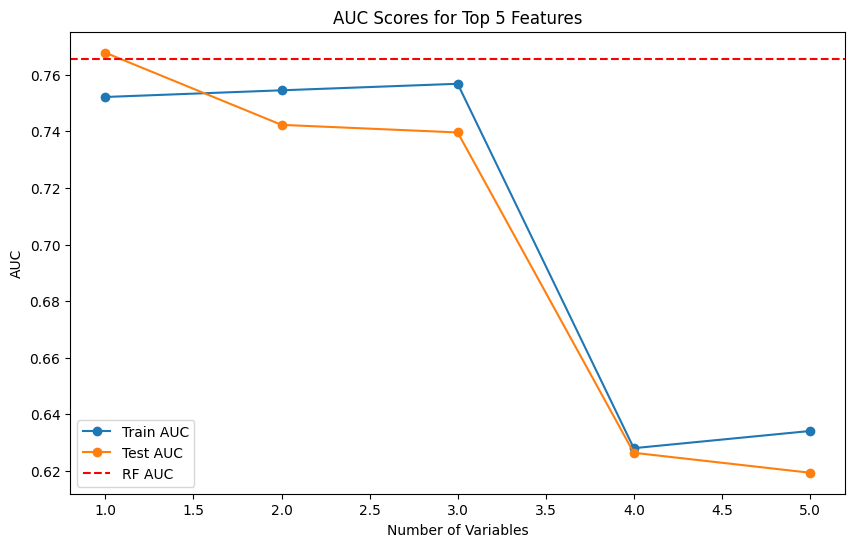

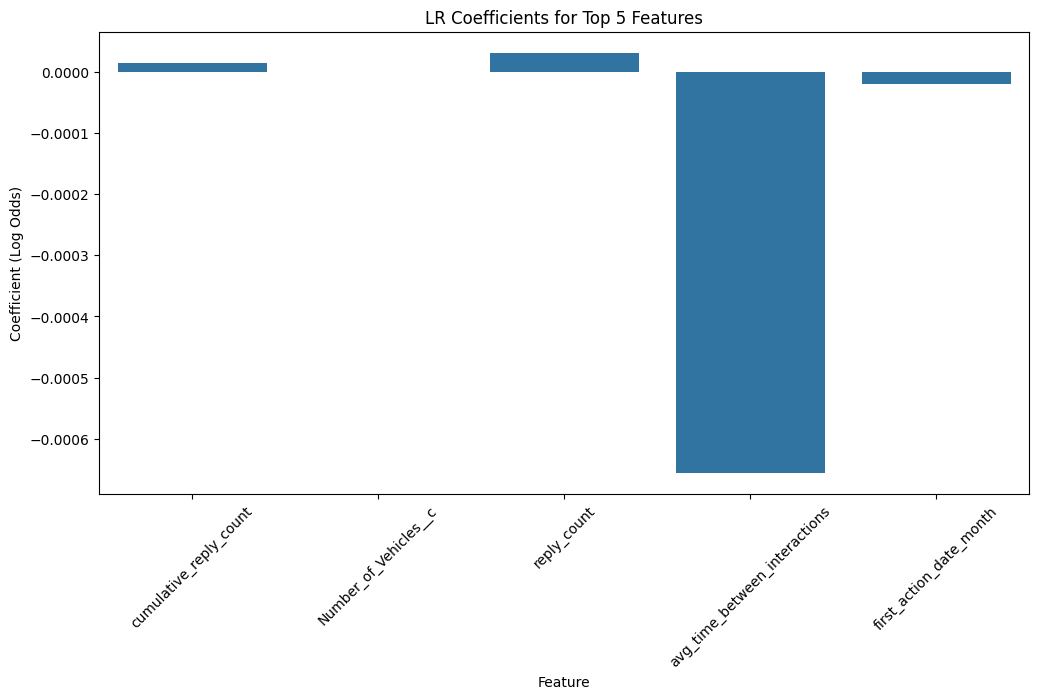

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311

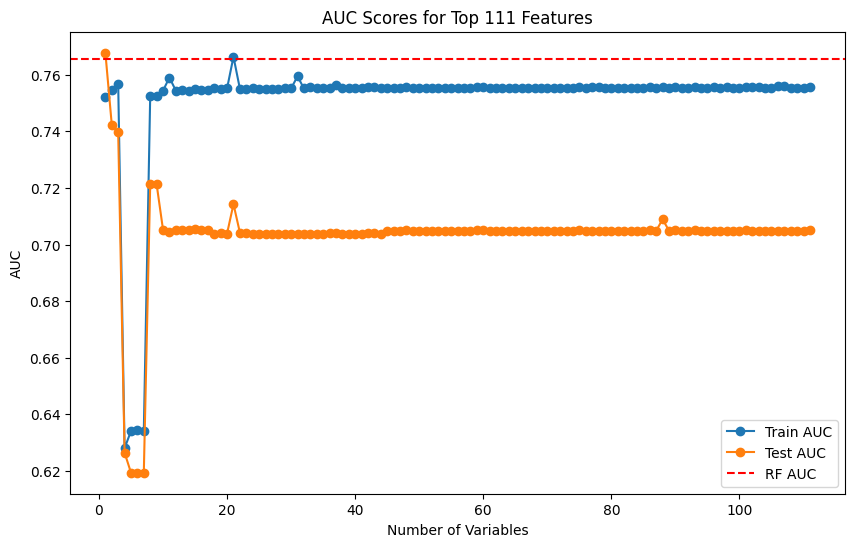

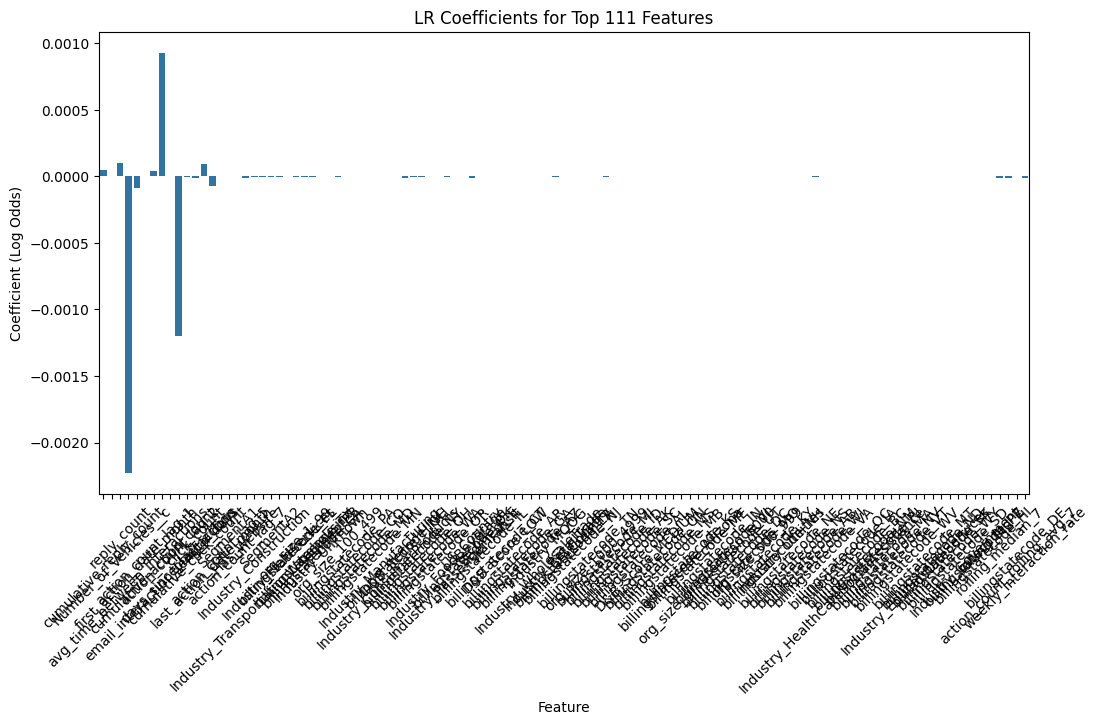

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Assuming X and y are already defined
# If X and y are not defined, you need to load and preprocess your data accordingly

# Function to streamline the process for the entire dataset
def model_for_entire_dataset(X, y, num_features):
    results = {}
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train RandomForestClassifier
    clf = RandomForestClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    
    # Calculate AUC score on validation set
    rf_auc_val = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    
    # Get feature importances
    feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    
    # Initialize lists
    base_clf_list = []
    train_auc_list = []
    test_auc_list = []
    
    for i in range(num_features):  # Limiting to the first num_features most important features
        feature_names = list(feature_importances_sorted.index[:i+1])
        
        base_clf = LogisticRegression(random_state=0, solver='newton-cg', penalty='l2', C=1.0)
        base_clf.fit(X_train[feature_names], y_train)
        
        # Calculate AUC scores
        train_auc = roc_auc_score(y_train, base_clf.predict_proba(X_train[feature_names])[:, 1])
        val_auc = roc_auc_score(y_val, base_clf.predict_proba(X_val[feature_names])[:, 1])
        
        base_clf_list.append(base_clf)
        train_auc_list.append(train_auc)
        test_auc_list.append(val_auc)
    
    # Store results
    results['feature_importances_sorted'] = feature_importances_sorted
    results['base_clf_list'] = base_clf_list
    results['train_auc_list'] = train_auc_list
    results['test_auc_list'] = test_auc_list
    results['rf_auc_val'] = rf_auc_val
    
    return results

def plot_results(X, y, num_features):
    # Train models and get results
    results = model_for_entire_dataset(X, y, num_features)
    
    # Plotting the results using Seaborn and Matplotlib
    def plot_auc_scores(results, num_features):
        x_axis = list(range(1, num_features + 1))
        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, results['train_auc_list'], marker='o', label='Train AUC')
        plt.plot(x_axis, results['test_auc_list'], marker='o', label='Test AUC')
        plt.axhline(y=results['rf_auc_val'], color='r', linestyle='--', label='RF AUC')
        plt.title(f'AUC Scores for Top {num_features} Features')
        plt.xlabel('Number of Variables')
        plt.ylabel('AUC')
        plt.legend()
        plt.show()

    def plot_lr_coefficients(results, num_features):
        coef = results['base_clf_list'][num_features - 1].coef_[0]
        features = list(results['feature_importances_sorted'].index[:num_features])
        plt.figure(figsize=(12, 6))
        sns.barplot(x=features, y=coef)
        plt.title(f'LR Coefficients for Top {num_features} Features')
        plt.xlabel('Feature')
        plt.ylabel('Coefficient (Log Odds)')
        plt.xticks(rotation=45)
        plt.show()

    plot_auc_scores(results, num_features)
    plot_lr_coefficients(results, num_features)

# Example usage
# plot_results(X_train, y_train, 10)
plot_results(X_train, y_train, 5)
# plot_results(X_train, y_train, 20)
plot_results(X_train, y_train, len(X_train.columns))

**End of Notebook**